# Stand-up comedy topic modeling across cultures
## Natural Language Processing (E1282) Research Note, Dr. Sascha Göbel
- Author: Lonny Chen (216697)
- Submission Date: 5 January 2026
### Contents
TODO section links

In [1]:
# Local environment
import sys
sys.path.append('../../')
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from data.data_collection import get_channels_shorts_video_ids, get_transcript_from_video_id
from data.data_preprocessing import find_annotations, custom_preprocessor_transcripts, vectorize_transcripts_to_bow
from data.data_preprocessing import custom_tokenizer_spacy0, custom_tokenizer_spacy1, custom_tokenizer_spacy_lemma
from data.data_plotting import plot_transcript_len, create_token_frequency, plot_zipf

## Data Collection
### Step 1: Get YouTube video IDs
- Use of [YT-DLP](https://github.com/yt-dlp/yt-dlp) for extracting video information is referenced from [StandUp4AI](https://github.com/Standup4AI/dataset/) project code.

In [3]:
%%time
# Input YouTube channel search information here
channels = [
    {
        'channel': 'Comedy Central Stand-Up',
        'search_url': 'https://www.youtube.com/@standup/shorts',
        'list_search_str': [],
        'language_code': 'en'
    },
    {
        'channel': 'Comedy Central UK',
        'search_url': 'https://www.youtube.com/@comedycentraluk/search?query=standup',
        'list_search_str': [],
        'language_code': 'en'
    }
]
#df_channels = get_channels_shorts_video_ids(channels=channels)
#df_channels.to_csv('data/df_channels.csv', index=False)
df_channels = pd.read_csv('data/df_channels.csv')
df_channels.shape

CPU times: user 2.49 ms, sys: 1.03 ms, total: 3.52 ms
Wall time: 3.97 ms


(768, 8)

### Step 2: Get transcript strings from video IDs
- Use [YouTube Transcript API](https://github.com/jdepoix/youtube-transcript-api) to fetch correct language transcripts
- Internally uses "Rotating Residential Proxy" from [Webshare](https://www.webshare.io/?referral_code=w0xno53eb50g) to workaround <span style="color:red">IpBlocked</span> exceptions

In [4]:
%%time
# TEST: one transcript fetch
video_id = 'JYjRBzuVFwQ' #test shorts
get_transcript_from_video_id(video_id, 'en', use_proxy=True)

Fetch completed for video 'JYjRBzuVFwQ'
CPU times: user 135 ms, sys: 33 ms, total: 168 ms
Wall time: 4.95 s


"it was great being in a relationship\nwith her but I didn't know like Latino\nwomen like I didn't know that like\nyou're under investigation like it's\njust when you date a Puerto Rican girl\nyou need to have the answers quick you\nneed to like have facts right away\nbecause they will interrogate you and if\nyou don't have the answers quick you\nlook like a liar and they watch men they\nare designed to watch men watching\nwaiting that's what they do they make\nexcellent NFL referees I think if you\nhad Puerto Rican girls reing the games\nyou'd have zero Miss calls the whole\nseason because they see everything so\nthat's just what could you imagine they\nwere the refs they would be right there\nlike um you out of bound stupid no\nno I mean for real you out of\nbounds I don't need instant replay I I\ninstantly saw you step out of bound so\nyou\nknow I mean I don't even know the rules\njust go home\nbye you out the game"

In [5]:
%%time
# FULL set of videos (2-3 hours for n=~770)
#df_channels['transcript'] = df_channels.apply(lambda row: get_transcript_from_video_id(row['video_id'], row['language_code']), axis=1)
# Save to CSV
#df_channels.to_csv('data/df_channels_transcripts.csv', index=False)

CPU times: user 2 μs, sys: 1e+03 ns, total: 3 μs
Wall time: 4.29 μs


In [6]:
# Read from saved CSV
df_transcripts = pd.read_csv('data/df_channels_transcripts.csv')
df_transcripts.shape

(768, 9)

In [7]:
df_transcripts.head(2)

,video_id,url,title,duration,view_count,channel,channel_id,language_code,transcript
0,JYjRBzuVFwQ,https://www.youtube.com/shorts/JYjRBzuVFwQ,"""If you had Puerto Rican girls reffing the gam...",NaN,192000.0,Comedy Central Stand-Up,@standup,en,it was great being in a relationship\nwith her...
1,Aay2CmDwAoU,https://www.youtube.com/shorts/Aay2CmDwAoU,"""I like professional football."" 🎤: Demetri Mar...",NaN,131000.0,Comedy Central Stand-Up,@standup,en,I like sports I like professional\nfootball I ...


## Data Proprocessing
### Step 0: Video-level cleaning
- Drop duplicate `video_id`s
- TODO: drop BEFORE fetching transcripts

In [8]:
# "Before" counts
df_transcripts['channel_id'].value_counts()

channel_id
@standup            404
@comedycentraluk    364
Name: count, dtype: int64

In [9]:
# Check and drop duplicate video_ids
# Note: video_ids and thus duplicates are unique per-channel (not across channels)
df_transcripts_clean = df_transcripts.drop_duplicates(subset=['video_id'])
df_transcripts_clean['channel_id'].value_counts()

channel_id
@standup            404
@comedycentraluk    313
Name: count, dtype: int64

### Step 1: Transcript-level cleaning
- Check for missing values
- Drop exception strings

In [10]:
# Check missing transcripts
print(f'Count of missing values in transcripts: {df_transcripts_clean['transcript'].isna().sum()}')
# Check caught exception transcripts
exceptions_list = ['TranscriptsDisabled', 'UnexpectedLanguage', 'ReachedListRetryLimit', 'ReachedFetchRetryLimit']
df_transcripts_clean[df_transcripts_clean['transcript'].isin(exceptions_list)][['url', 'transcript']]

Count of missing values in transcripts: 0


,url,transcript
205,https://www.youtube.com/shorts/AxPVZ2qCago,TranscriptsDisabled
380,https://www.youtube.com/shorts/VMsbSWNShzQ,TranscriptsDisabled
389,https://www.youtube.com/shorts/E_duIZZNcpI,UnexpectedLanguage
401,https://www.youtube.com/shorts/2o9jkV-DJ9I,TranscriptsDisabled
415,https://www.youtube.com/watch?v=BEMWzPUVe24,UnexpectedLanguage
578,https://www.youtube.com/watch?v=IDs4TvWEOUE,TranscriptsDisabled


In [11]:
# Drop and "after" counts
df_transcripts_clean2 = df_transcripts_clean[~df_transcripts_clean['transcript'].isin(exceptions_list)]
df_transcripts_clean2['channel_id'].value_counts()

channel_id
@standup            400
@comedycentraluk    311
Name: count, dtype: int64

### Step 2: Tokenization/vectorization
Follow a systematic tokenization/vectorization strategy based on the iterations below. The baseline "iteration 0" case uses the SpaCy [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) English "smart" rules-based [tokenization](https://spacy.io/usage/linguistic-features#tokenization) with no stop words. Scikit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) creates the "document-term (sparse) matrix", i.e. "Bag of Words".

The custom preprocessor removes transcript annotations (e.g., `[Applause]`) and is the "iteration 0" baseline. Further iterations:
1. Remove "non-words": whitespace, punctuation, digit-only tokens, single characters
2. Remove list of SpaCy English `STOP_WORDS` (to match SpaCy tokenization, e.g. tokenized contractions)
3. Remove list of context-specific stop words from manual review (conversational utterances)
4. Use SpaCy lemmatized tokens

In [12]:
# Download spaCy tokenizer model (run once)
spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 4.8 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [13]:
# Find set of transcript annotations
find_annotations(df_transcripts_clean2['transcript'])

{'[Applause]', '[Laughter]', '[Music]', '[\xa0__\xa0]'}

In [14]:
# TEST custom preprocessor (re)
test_text = "Hello world [Music].\nLet's go to \"N.Y.\", for 'around' - $200!? [Applause]."
custom_preprocessor_transcripts(test_text)

'hello world .\nlet\'s go to "n.y.", for \'around\' - $200!? .'

In [15]:
# TEST custom tokenizer (SpaCy)
custom_tokenizer_spacy1(custom_preprocessor_transcripts(test_text))

['hello', 'world', 'let', "'s", 'go', 'to', 'n.y', 'for', 'around']

#### 2.0 Baseline (preprocessor only)

In [16]:
# Start vocab size collecton
vocab_size = []

In [17]:
%%time
# Call with spacy0 (no other filtering)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy0
                                                    )
vocab_size.append({'CountVectorizer': 'Baseline (preprocessor only)', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens0.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2min 53s, sys: 4.96 s, total: 2min 58s
Wall time: 2min 58s


#### 2.1 Remove non-words (SpaCy Token attributes)

In [18]:
%%time
# Call with spacy1 (filter inside tokenizer)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy1
                                                    )
vocab_size.append({'CountVectorizer': 'Remove spaces, punctuation, digits, single chars', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens1.txt', transcripts_bow_tuple[1], fmt='%s')

CPU times: user 2min 56s, sys: 5.34 s, total: 3min 1s
Wall time: 3min 2s


#### 2.2 Remove SpaCy STOP_WORDS

In [19]:
# Get and save SpaCy English STOP_WORDS
spacy_en_stop_words = sorted(list(STOP_WORDS))
np.savetxt('data/spacy_en_stop_words.txt', np.array(spacy_en_stop_words), fmt='%s')

In [20]:
%%time
# Call with stop_words
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy1,
                                                     stop_words=spacy_en_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Remove SpaCy stop words', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens2.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 17s, sys: 7.33 s, total: 4min 24s
Wall time: 4min 26s


#### 2.3 Remove context stop words

In [21]:
# Add to list of stop words
context_stop_words = ['ah', 'aha', 'hmm', 'oh', 'oo', 'ooh', 'uh', 'uhhuh', 'um']
all_stop_words = spacy_en_stop_words + context_stop_words

In [22]:
%%time
# Call with additional stop_words
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy1,
                                                     stop_words=all_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Remove context-specific stop words', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens3.txt', transcripts_bow_tuple[1], fmt='%s')

CPU times: user 4min 17s, sys: 6.99 s, total: 4min 24s
Wall time: 4min 25s


#### 2.4 Use SpaCy lemmatization

In [23]:
# TEST custom tokenizer/lemmatizer (SpaCy)
test_text = 'She goes to buy apples. He went and bought an apple.'
custom_tokenizer_spacy_lemma(test_text)

['she', 'go', 'to', 'buy', 'apple', 'he', 'go', 'and', 'buy', 'an', 'apple']

In [24]:
%%time
# Call using lemmatized tokens
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy_lemma,
                                                     stop_words=all_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Use lemmatized tokens', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens4.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'll', 'regard', 'use', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 34s, sys: 7.77 s, total: 4min 42s
Wall time: 4min 44s


In [25]:
pd.DataFrame(vocab_size)

,CountVectorizer,vocab_size
0,Baseline (preprocessor only),7132
1,"Remove spaces, punctuation, digits, single chars",7005
2,Remove SpaCy stop words,6735
3,Remove context-specific stop words,6726
4,Use lemmatized tokens,5440


### Step 3: Explore "Bag of Words" document-term matrix
Plots:
1. Per-document token length distribution
2. Per-token rank vs. frequency to check Zipf's law (linear-linear and log-log plots)

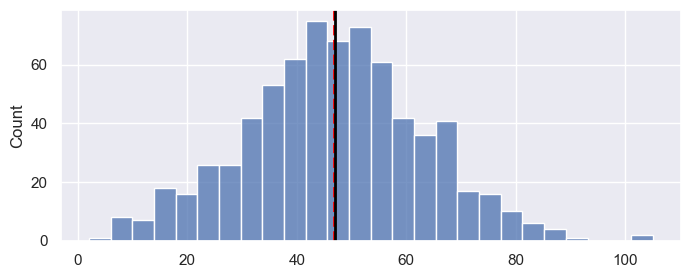

In [26]:
# Plot per-document token length distribution
transcript_lengths_array = np.asarray(transcripts_bow_tuple[0].sum(axis=1)).ravel()
plot_transcript_len(pd.Series(transcript_lengths_array))

In [27]:
# Create DF from BoW matrix and feature names
df_token_frequency = create_token_frequency(transcripts_bow_tuple)
df_token_frequency.head()

,token,total_frequency,doc_frequency,total_rank,doc_rank
0,like,2050,565,1,1
1,know,954,462,2,2
2,I,701,368,3,3
3,right,447,285,4,4
4,think,343,234,5,5


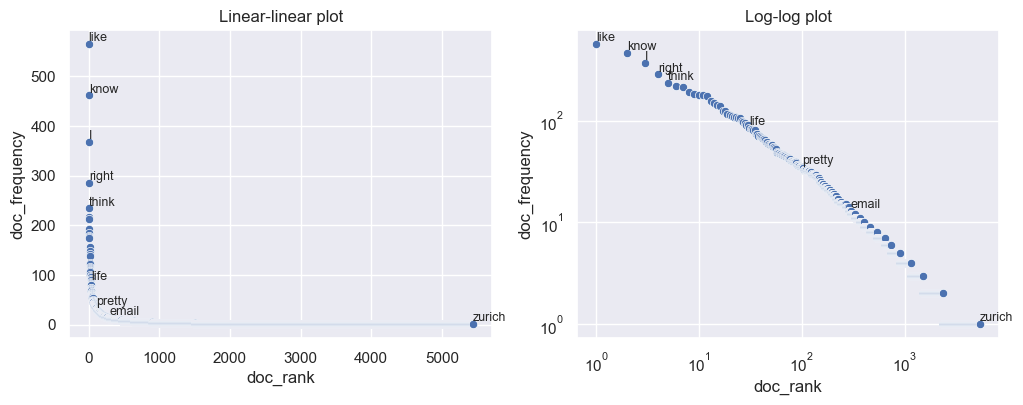

In [34]:
plot_zipf(df_token_frequency, rank_by='doc', top_n=5, bottom_n=1, mid_ranks = [30, 100, 300])

### Step 4: Set rare word cut-off (min_df)
Keeping very rare words results in unneeded noise for topic modeling.
- Set the "cut-off" to a minimum of 2 meaning tokens appearing in only 1 document are removed from the vocabulary.

In [29]:
%%time
features_dict = {
    'max_features': None, #default: None
    'max_df': 1.0, #default: 1.0 (float)
    'min_df': 2 #default: 1 (int)
}
# Call using features_dict (min_df)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy_lemma,
                                                     stop_words=all_stop_words,
                                                     features_dict=features_dict
                                                    )
vocab_size.append({'CountVectorizer': 'Set min_df', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens5.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'll', 'regard', 'use', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 34s, sys: 7.84 s, total: 4min 42s
Wall time: 4min 44s


In [30]:
# Print collected iterations of vocabulary size
pd.DataFrame(vocab_size)

,CountVectorizer,vocab_size
0,Baseline (preprocessor only),7132
1,"Remove spaces, punctuation, digits, single chars",7005
2,Remove SpaCy stop words,6735
3,Remove context-specific stop words,6726
4,Use lemmatized tokens,5440
5,Set min_df,2349


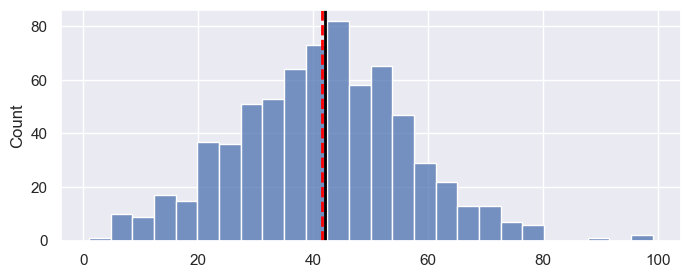

In [32]:
# Plot per-document token length distribution AFTER setting min_df
transcript_lengths_array = np.asarray(transcripts_bow_tuple[0].sum(axis=1)).ravel()
plot_transcript_len(pd.Series(transcript_lengths_array))

In [33]:
# Check BoW matrix size before LDiA
transcripts_bow_tuple[0]

<711x2349 sparse matrix of type '<class 'numpy.int64'>'
	with 21168 stored elements in Compressed Sparse Row format>